### Imports

In [41]:
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup
import time
from random import randint
from pymongo import MongoClient
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### Connect to MongoDB

In [3]:
client = MongoClient()
sci = client.metis_p4_db.science

In [42]:
year_2016 = sci.find({'year': 2016})
year_2016[0]

{'_id': ObjectId('59f8f1ca127ab45bd3582636'),
 'description': "Antibiotic resistance threatens to put modern medicine into reverse. But we are not at the end of our options for currently available drugs. Baym et al. review what can be done by using combinations of antibiotics to circumvent bacteria's evolutionary strategies. For instance, resistance to one drug may cause sensitivity to another, the effectiveness of two drugs can be synergized by a resistance mutation, and some negative drug interactions may even be beneficial in selecting against resistance. Although not simple to assess, drug combinations still have something to offer for the development of sorely needed anti-infectives.",
 'title': 'Multidrug evolutionary strategies to reverse antibiotic resistance',
 'year': 2016}

In [43]:
year_2016[0]['description']

"Antibiotic resistance threatens to put modern medicine into reverse. But we are not at the end of our options for currently available drugs. Baym et al. review what can be done by using combinations of antibiotics to circumvent bacteria's evolutionary strategies. For instance, resistance to one drug may cause sensitivity to another, the effectiveness of two drugs can be synergized by a resistance mutation, and some negative drug interactions may even be beneficial in selecting against resistance. Although not simple to assess, drug combinations still have something to offer for the development of sorely needed anti-infectives."

In [44]:
all_descriptions = []

for record in year_2016:
    all_descriptions.append(record['description'])

In [45]:
all_descriptions[:2]

["Antibiotic resistance threatens to put modern medicine into reverse. But we are not at the end of our options for currently available drugs. Baym et al. review what can be done by using combinations of antibiotics to circumvent bacteria's evolutionary strategies. For instance, resistance to one drug may cause sensitivity to another, the effectiveness of two drugs can be synergized by a resistance mutation, and some negative drug interactions may even be beneficial in selecting against resistance. Although not simple to assess, drug combinations still have something to offer for the development of sorely needed anti-infectives.",
 'In carpenter ants, separate behavioral classes, known as castes, are determined by the epigenetic regulation of genes. Simola et al. treated ants of different castes with drugs that affected histone acetylation. Reducing histone acetylation stimulated scouting and foraging behavior. The foraging and scouting behaviors of young ants were permanently changed 

In [46]:
len(all_descriptions)

1877

In [52]:
from spacy.en import STOP_WORDS as stopwords
import string
import spacy
nlp = spacy.load('en')
stopwords.update(['et', 'al', "'s"])
punctuations = string.punctuation

### change max features

In [87]:
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2), max_df = 0.6, max_features=5000)

In [88]:
X_spacy = vectorizer.fit_transform(all_descriptions)

In [89]:
X_spacy.shape

(1877, 5000)

In [90]:
n_topics = 10
n_iter = 10
lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=n_iter,
                                random_state=42,
                               learning_method='online')
data = lda.fit_transform(X_spacy)
data[:3]

array([[ 0.00232632,  0.00232559,  0.00232633,  0.97906561,  0.00232601,
         0.00232589,  0.00232612,  0.00232588,  0.00232582,  0.00232642],
       [ 0.00312546,  0.003125  ,  0.1815002 ,  0.37891587,  0.20312908,
         0.00312537,  0.0031252 ,  0.00312579,  0.00312561,  0.21770241],
       [ 0.00131587,  0.00131579,  0.00131595,  0.00131595,  0.04398058,
         0.00131592,  0.00131588,  0.00131591,  0.0013158 ,  0.94549233]])

In [91]:
display_topics(lda,vectorizer.get_feature_names(),10)

Topic  0
science research new scientific scientist human state drug work social
Topic  1
planet solar star surface system crater ice comet solar system spacecraft
Topic  2
climate change global year impact climate change world water increase ocean
Topic  3
protein gene dna rna genetic genome potential use information interest
Topic  4
cell cancer disease immune t tissue tumor t cell mouse virus
Topic  5
quantum use material state electron earth system optical atom particle
Topic  6
new researcher research u.s world year science health scientist national
Topic  7
reaction carbon molecule use bond metal enzyme complex structure oxygen
Topic  8
gravitational wave crispr physicist university gravitational wave student muscle career new
Topic  9
human plant study brain animal 1 specie new page system


## Workflow

#### Write function for tokenizer

In [410]:
def spacy_tokenizer_1(doc):
    doc = doc.replace('—', '').replace(',', '').replace("'s", '')
    doc = re.sub('\s\d+\s', '', doc)
    tokens = nlp(doc)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]     
    return tokens

In [411]:
def spacy_tokenizer_2(doc):
    doc = doc.replace('—', '').replace(',', '').replace("'s", '')
    doc = re.sub('\s\d+(\s)?', '', doc)
    tokens = nlp(doc)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]     
    return tokens

In [436]:
def spacy_tokenizer_3(doc):
    doc = doc.replace('—', '').replace(',', '').replace("'s", '')
    # doc = re.sub('\s\d+(\s)?(,)?', ' ', doc)
    doc = re.sub('\D\d+(\D)?', ' ', doc)
    doc = doc.replace('–', '')
    tokens = nlp(doc)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]     
    return tokens

#### Functions for vectorizing

In [117]:
def count_vectorizer(tokenizer, max_feat, X, ngram_start=1, ngram_stop=2, max_df=0.6):

    vectorizer = CountVectorizer(tokenizer = tokenizer,
                                 ngram_range=(ngram_start, ngram_stop),
                                 max_df = max_df,
                                 max_features=max_feat)
    return vectorizer, vectorizer.fit_transform(X)

In [118]:
def tfidf_vectorizer(tokenizer, max_feat, X, ngram_start=1, ngram_stop=2, max_df=0.6):

    vectorizer = TfidfVectorizer(tokenizer = tokenizer,
                                 ngram_range=(ngram_start, ngram_stop),
                                 max_df = max_df,
                                 max_features=max_feat)
    return vectorizer, vectorizer.fit_transform(X)

#### Write functions for models

In [105]:
from sklearn.decomposition import NMF, TruncatedSVD

In [405]:
def lda_cv(X, n_comp, n_iter = 10):
    lda = LatentDirichletAllocation(n_components=n_comp,
                                    max_iter=n_iter,
                                    random_state=42,
                                    learning_method='online')
    return lda, lda.fit_transform(X)

def lda_tfidf(X, n_comp, n_iter = 10):
    lda = LatentDirichletAllocation(n_components=n_comp,
                                    max_iter=n_iter,
                                    random_state=42,
                                    learning_method='online')
    return lda, lda.fit_transform(X)

In [268]:
def lsa_tfidf(X, n_comp):
    lsa = TruncatedSVD(n_components=n_comp, random_state=42)
    return lsa, lsa.fit_transform(X)
def lsa_cv(X, n_comp):
    lsa = TruncatedSVD(n_components=n_comp, random_state=42)
    return lsa, lsa.fit_transform(X)
def nmf_tfidf(X, n_comp):
    nmf = NMF(n_components=n_comp, random_state=42)
    return nmf, nmf.fit_transform(X)
def nmf_cv(X, n_comp):
    nmf = NMF(n_components=n_comp, random_state=42)
    return nmf, nmf.fit_transform(X)

#### function for displaying topics

In [230]:
def display_topics(model, feature_names, no_top_words):
    for ix, topic in enumerate(model.components_):
        print("Topic ", ix)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### Make function for modeling and printing results

In [523]:
def use_vectorizer(cv_vect, cv_vect_trans, n_comp=10):
    models = [lsa_cv, nmf_cv, lda_tfidf]
    names = ['LSA', 'NMF', 'LDA']
    i = 0
    for item in models:
        model, model_transformed = item(cv_vect_trans, n_comp=n_comp)
        print('\n\n-------' + names[i] + '------\n\n')
        display_topics(model, cv_vect.get_feature_names(), 10)
        i += 1

# Make different vectorizers and test models (LSA, NMF, LDA)

count vectorizer 1

In [427]:
cv_vect1, cv_vect1_transformed = count_vectorizer(spacy_tokenizer_1, 5000, all_descriptions)

In [416]:
use_vectorizer(cv_vect1, cv_vect1_transformed)



-------LSA------


Topic  0
cell new use human science study protein research system disease
Topic  1
cell t t cell immune protein cancer mouse tumor tissue stem cell
Topic  2
science research cell new world scientist u.s national researcher institute
Topic  3
system surface solar pluto new material new horizon horizon cell datum
Topic  4
gene protein human disease new virus system dna rna genome
Topic  5
change climate climate change human virus global specie ice cause impact
Topic  6
virus researcher material information potential offer human laboratory instrumentation roundup
Topic  7
virus zika vaccine antibody infect use zika virus infection atom report
Topic  8
protein virus structure antibody change climate zika bind vaccine science
Topic  9
1 issue 2 pageof pageof issue science 3 system report immune


-------NMF------


Topic  0
use state material atom high electron quantum carbon reaction light
Topic  1
cell t t cell immune cancer stem mouse stem cell tumor tissue
Topic  2


try fewer topics

In [430]:
use_vectorizer(cv_vect1, cv_vect1_transformed, n_comp=12)



-------LSA------


Topic  0
cell new use human science study protein research system disease
Topic  1
cell t t cell immune protein cancer mouse tumor tissue stem cell
Topic  2
science research cell new world scientist u.s national researcher institute
Topic  3
system surface solar pluto new material new horizon horizon cell datum
Topic  4
gene protein human disease new system virus dna rna genome
Topic  5
change climate climate change human global virus specie ice cause impact
Topic  6
virus researcher material potential information offer human laboratory instrumentation roundup
Topic  7
virus zika vaccine antibody use infect zika virus infection health atom
Topic  8
protein virus structure change antibody climate bind zika science complex
Topic  9
1 issue 2 pageof pageof issue 3 system science report disease
Topic  10
carbon bond – c reaction h plant c – – h h bond
Topic  11
brain new protein study wave year gravitational earth human star


-------NMF------


Topic  0
use state mate

count vectorizer 2

In [417]:
cv_vect2, cv_vect2_transformed = count_vectorizer(spacy_tokenizer_1, 5000, all_descriptions, ngram_stop=4)

In [418]:
use_vectorizer(cv_vect2, cv_vect2_transformed)



-------LSA------


Topic  0
cell new use human science study protein research system disease
Topic  1
cell t t cell immune protein cancer mouse tumor tissue stem cell
Topic  2
system surface material pluto solar new horizon horizon solar system complex present
Topic  3
researcher material information potential offer laboratory interest newly apparatus material potential
Topic  4
science cell new research system pluto solar researcher horizon new horizon
Topic  5
gene protein human disease virus dna rna genome genetic new
Topic  6
change climate human virus climate change specie global cause ice response
Topic  7
virus zika vaccine study use infect antibody zika virus human infection
Topic  8
protein virus antibody structure zika vaccine carbon bind complex science
Topic  9
1 issue 2 pageof pageof issue science 3 report system immune


-------NMF------


Topic  0
use material state atom high electron quantum light carbon reaction
Topic  1
cell t t cell immune cancer mouse stem stem ce

count vectorizer 3

In [419]:
cv_vect3, cv_vect3_transformed = count_vectorizer(spacy_tokenizer_1, 110000, all_descriptions)

In [420]:
use_vectorizer(cv_vect3, cv_vect3_transformed)



-------LSA------


Topic  0
cell new use human science study protein research system disease
Topic  1
cell t t cell immune protein cancer mouse tumor tissue stem cell
Topic  2
science cell research new scientist world u.s national researcher institute
Topic  3
system surface solar material cell pluto new new horizon horizon datum
Topic  4
gene system protein new human disease virus pluto horizon new horizon
Topic  5
change climate climate change virus human global specie cause ice increase
Topic  6
virus researcher material human zika study information vaccine use potential
Topic  7
virus antibody zika vaccine structure infect zika virus report bond reaction
Topic  8
protein change virus climate structure potential antibody newly material interest
Topic  9
1 issue 2 pageof pageof issue science system 3 immune report


-------NMF------


Topic  0
use state material atom electron quantum high reaction magnetic carbon
Topic  1
cell t t cell immune cancer mouse stem stem cell tumor tissu

tfidf vectorizer 1

In [421]:
tf_vect1, tf_vect1_transformed = tfidf_vectorizer(spacy_tokenizer_1, 5000, all_descriptions)

In [422]:
use_vectorizer(tf_vect1, tf_vect1_transformed)



-------LSA------


Topic  0
apparatus laboratory interest researcher weekly potential interest roundup information offer instrumentation instrumentation apparatus information newly weekly roundup newly offer
Topic  1
cell science new use human research study change gene protein
Topic  2
cell protein t gene t cell immune tumor dna expression cancer
Topic  3
cell science cancer t t cell research immune disease tumor virus
Topic  4
cell science t t cell quantum material atom research solar electron
Topic  5
protein dna gene rna structure science complex genome enzyme research
Topic  6
virus zika vaccine antibody zika virus infect infection viral ebola outbreak
Topic  7
carbon reaction bond c catalyst plant climate enzyme science methane
Topic  8
protein change climate structure science policy climate change electron state bind
Topic  9
protein ice planet earth surface structure year star solar gravitational


-------NMF------


Topic  0
offer instrumentation interest researcher weekly w

tfidf vectorizer 2

In [423]:
tf_vect2, tf_vect2_transformed = tfidf_vectorizer(spacy_tokenizer_1, 5000, all_descriptions, ngram_stop=4)

In [424]:
use_vectorizer(tf_vect2, tf_vect2_transformed)



-------LSA------


Topic  0
potential interest newly offer instrumentation apparatus instrumentation apparatus weekly roundup instrumentation apparatus laboratory instrumentation apparatus laboratory material information newly offer instrumentation weekly roundup information newly offer instrumentation roundup information newly
Topic  1
cell science new use human research study change gene protein
Topic  2
cell protein gene t t cell immune tumor dna expression cancer
Topic  3
cell science cancer t t cell research immune tumor disease virus
Topic  4
gene specie human change climate plant genome virus genetic rna
Topic  5
protein dna gene rna structure science genome complex enzyme research
Topic  6
virus zika vaccine antibody zika virus infect infection viral ebola outbreak
Topic  7
carbon reaction bond c catalyst plant enzyme climate protein science
Topic  8
protein change climate structure science climate change policy bind electron rna
Topic  9
ice protein planet earth year gravita

tfidf vectorizer 3

In [425]:
tf_vect3, tf_vect3_transformed = tfidf_vectorizer(spacy_tokenizer_1, 110000, all_descriptions)

In [426]:
use_vectorizer(tf_vect3, tf_vect3_transformed)



-------LSA------


Topic  0
offer instrumentation apparatus laboratory newly offer instrumentation apparatus weekly roundup weekly potential interest information newly interest researcher roundup information
Topic  1
cell new science use human protein gene change system study
Topic  2
cell t t cell immune protein gene tumor cancer mouse tissue
Topic  3
surface pluto solar system material new horizon atom horizon electron quantum
Topic  4
pluto cell new horizon horizon solar system surface moon solar system t
Topic  5
gene protein virus rna antibody dna human vaccine genome zika
Topic  6
virus antibody zika vaccine infect zika virus viral ebola ebola virus infection
Topic  7
climate change ice climate change specie plant global co2 impact increase
Topic  8
carbon bond c reaction h catalyst – enzyme c – complex
Topic  9
protein structure leucine mtorc1 electron climate change bind complex t


-------NMF------


Topic  0
offer instrumentation weekly roundup laboratory material instrumen

# test with tokenizer 3

count vectorizer 1

In [437]:
cv_vect1, cv_vect1_transformed = count_vectorizer(spacy_tokenizer_3, 5000, all_descriptions)

In [438]:
use_vectorizer(cv_vect1, cv_vect1_transformed)



-------LSA------


Topic  0
cell new use science human study year protein research system
Topic  1
cell t t cell immune protein cancer mouse tumor tissue stem cell
Topic  2
science cell research new world scientist u.s year national researcher
Topic  3
system surface solar pluto cell material new new horizon horizon datum
Topic  4
gene human protein new system disease virus pluto horizon new horizon
Topic  5
change climate climate change human virus global specie ice cause impact
Topic  6
virus researcher material potential information offer human laboratory instrumentation roundup
Topic  7
virus use zika antibody vaccine infect state atom zika virus quantum
Topic  8
protein virus antibody structure zika vaccine infect science change bind
Topic  9
state system quantum issue science research united page immune page issue


-------NMF------


Topic  0
science research u.s new national world scientist institute health scientific
Topic  1
cell t t cell immune cancer stem mouse stem cell 

try fewer topics

In [456]:
cv_vect1, cv_vect1_transformed = count_vectorizer(spacy_tokenizer_3, 5000, all_descriptions)
use_vectorizer(cv_vect1, cv_vect1_transformed, n_comp=12)



-------LSA------


Topic  0
cell new use science human study year protein research system
Topic  1
cell t t cell immune protein cancer mouse tumor tissue stem cell
Topic  2
science cell research new world scientist u.s year national researcher
Topic  3
system surface solar pluto cell material new new horizon horizon datum
Topic  4
gene system protein human new disease virus pluto horizon new horizon
Topic  5
change climate climate change human global virus specie ice cause impact
Topic  6
virus researcher material potential information human offer laboratory instrumentation roundup
Topic  7
virus use zika vaccine antibody state infect atom quantum zika virus
Topic  8
protein virus structure antibody zika vaccine change bind science infect
Topic  9
year carbon protein earth new wave gravitational form ice scientist
Topic  10
state protein quantum time brain study electron change wave year
Topic  11
immune t issue system page t cell page issue human science response


-------NMF------


In [439]:
use_vectorizer(cv_vect1, cv_vect1_transformed, n_comp=12)



-------LSA------


Topic  0
cell new use science human study year protein research system
Topic  1
cell t t cell immune protein cancer mouse tumor tissue stem cell
Topic  2
science cell research new world scientist u.s year national researcher
Topic  3
system surface solar pluto cell material new new horizon horizon datum
Topic  4
gene system protein human new disease virus pluto horizon new horizon
Topic  5
change climate climate change human global virus specie ice cause impact
Topic  6
virus researcher material potential information human offer laboratory instrumentation roundup
Topic  7
virus use zika vaccine antibody state infect atom quantum zika virus
Topic  8
protein virus structure antibody zika vaccine change bind science infect
Topic  9
year carbon protein earth new wave gravitational form ice scientist
Topic  10
state protein quantum time brain study electron change wave year
Topic  11
immune t issue system page t cell page issue human science response


-------NMF------


count vectorizer 2

In [442]:
cv_vect2, cv_vect2_transformed = count_vectorizer(spacy_tokenizer_3, 5000, all_descriptions, ngram_stop=4)

In [443]:
use_vectorizer(cv_vect2, cv_vect2_transformed)



-------LSA------


Topic  0
cell new use science human study year protein research system
Topic  1
cell t t cell immune protein cancer mouse tumor tissue stem cell
Topic  2
system material surface pluto solar use new horizon horizon complex protein
Topic  3
system pluto surface solar new horizon horizon present solar system include complex
Topic  4
cell science new research system pluto solar horizon year new horizon
Topic  5
gene protein human disease virus dna genome new rna genetic
Topic  6
change climate virus human climate change specie global cause ice increase
Topic  7
virus use zika study vaccine infect antibody zika virus atom infection
Topic  8
protein virus antibody structure zika vaccine infect bind zika virus hiv
Topic  9
year carbon protein c new wave gravitational ice earth plant


-------NMF------


Topic  0
use state material atom high quantum issue electron page page issue
Topic  1
cell t t cell immune cancer stem mouse stem cell tumor tissue
Topic  2
system pluto s

count vectorizer 3

In [444]:
cv_vect3, cv_vect3_transformed = count_vectorizer(spacy_tokenizer_3, 110000, all_descriptions)

In [445]:
use_vectorizer(cv_vect3, cv_vect3_transformed)



-------LSA------


Topic  0
cell new use science human study year protein research system
Topic  1
cell t t cell immune protein cancer mouse tumor tissue stem cell
Topic  2
science cell research new world scientist u.s year national researcher
Topic  3
system surface solar cell material pluto new horizon horizon datum ice
Topic  4
system new gene human disease pluto protein virus horizon new horizon
Topic  5
change climate virus climate change human specie global cause ice impact
Topic  6
virus researcher material use study information human zika potential vaccine
Topic  7
virus antibody protein zika vaccine structure infect zika virus hiv infection
Topic  8
protein change potential climate interest material newly offer material potential apparatus
Topic  9
state system quantum issue science research immune united page page issue


-------NMF------


Topic  0
science research new u.s national world scientist institute health scientific
Topic  1
cell t t cell immune cancer stem mouse 

tfidf vectorizer 1

In [446]:
tf_vect1, tf_vect1_transformed = tfidf_vectorizer(spacy_tokenizer_3, 5000, all_descriptions)

In [447]:
use_vectorizer(tf_vect1, tf_vect1_transformed)



-------LSA------


Topic  0
apparatus laboratory weekly roundup laboratory material potential interest instrumentation apparatus offer instrumentation interest researcher weekly newly offer information newly
Topic  1
cell science new use human research year study change gene
Topic  2
cell protein gene t t cell immune tumor dna expression cancer
Topic  3
cell science cancer t t cell immune research disease tumor virus
Topic  4
cell science t t cell quantum material solar atom state research
Topic  5
climate change cell climate change ice t t cell global impact immune
Topic  6
virus zika vaccine antibody zika virus infect hiv infection viral ebola
Topic  7
carbon reaction c bond catalyst protein science enzyme plant climate
Topic  8
plant year reaction star gravitational planet carbon new researcher wave
Topic  9
protein ice planet surface year dna earth structure climate rna


-------NMF------


Topic  0
instrumentation apparatus roundup information weekly laboratory material newly of

tfidf vectorizer 2

In [448]:
tf_vect2, tf_vect2_transformed = tfidf_vectorizer(spacy_tokenizer_3, 5000, all_descriptions, ngram_stop=4)

# THIS ONE IS GOOD

In [449]:
use_vectorizer(tf_vect2, tf_vect2_transformed)



-------LSA------


Topic  0
instrumentation apparatus laboratory instrumentation apparatus laboratory material laboratory material potential interest newly offer instrumentation material potential interest researcher apparatus laboratory material potential information newly offer information newly offer instrumentation material potential interest laboratory material potential
Topic  1
cell science new use human research year study change gene
Topic  2
cell protein gene t t cell immune tumor dna expression cancer
Topic  3
cell science cancer t t cell immune research tumor disease virus
Topic  4
cell science t t cell quantum material atom research solar state
Topic  5
climate change cell climate change ice t t cell global impact immune
Topic  6
virus zika vaccine antibody zika virus infect hiv infection viral ebola
Topic  7
carbon reaction c bond catalyst protein enzyme plant science climate
Topic  8
protein change climate science structure policy state climate change electron quantum


In [521]:
tf_vect2, tf_vect2_transformed = tfidf_vectorizer(spacy_tokenizer_3, 5000, all_descriptions, ngram_stop=3)

# THIS ONE IS THE BEST

In [524]:
use_vectorizer(tf_vect2, tf_vect2_transformed)



-------LSA------


Topic  0
offer instrumentation apparatus material potential interest newly offer instrumentation newly offer apparatus laboratory material apparatus laboratory instrumentation apparatus instrumentation apparatus laboratory roundup information newly roundup information
Topic  1
cell science new use human research year study change gene
Topic  2
cell protein gene t t cell immune tumor dna expression rna
Topic  3
cell science cancer t t cell immune research disease tumor virus
Topic  4
cell science t t cell quantum material atom solar state electron
Topic  5
protein dna science gene rna structure complex genome research enzyme
Topic  6
virus vaccine zika antibody zika virus infect hiv infection viral ebola
Topic  7
carbon reaction c bond catalyst protein plant enzyme science climate
Topic  8
plant year reaction carbon gravitational star researcher new wave catalyst
Topic  9
ice protein dna year earth planet surface crater climate star


-------NMF------


Topic  0
wee

tfidf vectorizer 3

In [450]:
tf_vect3, tf_vect3_transformed = tfidf_vectorizer(spacy_tokenizer_3, 110000, all_descriptions)

# THIS ONE IS GOOD

In [451]:
use_vectorizer(tf_vect3, tf_vect3_transformed)



-------LSA------


Topic  0
weekly roundup newly offer roundup information laboratory material offer instrumentation instrumentation apparatus information newly potential interest weekly apparatus laboratory
Topic  1
cell new science use human protein gene change research study
Topic  2
cell t t cell protein immune gene tumor cancer mouse dna
Topic  3
pluto surface solar system new horizon material horizon atom electron quantum
Topic  4
pluto cell new horizon horizon solar system t t cell moon solar system
Topic  5
virus gene protein antibody rna dna vaccine human zika genome
Topic  6
virus antibody vaccine zika infect hiv zika virus viral ebola infection
Topic  7
climate change ice climate change specie plant c global impact temperature
Topic  8
protein carbon complex leucine reaction mtor c bond enzyme science
Topic  9
flow fluid electron plant protein immune graphene response t t cell


-------NMF------


Topic  0
potential interest instrumentation apparatus newly offer laboratory

# THIS ONE IS THE BEST, try TSNE

In [525]:
tf_vect2, tf_vect2_transformed = tfidf_vectorizer(spacy_tokenizer_3, 5000, all_descriptions, ngram_stop=3)

In [526]:
model, model_transformed = nmf_cv(tf_vect2_transformed, n_comp=3)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1877 samples in 0.003s...
[t-SNE] Computed neighbors for 1877 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1877
[t-SNE] Computed conditional probabilities for sample 1877 / 1877
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.075s
[t-SNE] Iteration 50: error = 71.5460434, gradient norm = 0.1214279 (50 iterations in 2.343s)
[t-SNE] Iteration 100: error = 65.5536423, gradient norm = 0.0198547 (50 iterations in 1.712s)
[t-SNE] Iteration 150: error = 65.1880341, gradient norm = 0.0022966 (50 iterations in 1.727s)
[t-SNE] Iteration 200: error = 65.1220245, gradient norm = 0.0041442 (50 iterations in 1.735s)
[t-SNE] Iteration 250: error = 65.0985565, gradient norm = 0.0020528 (50 iterations in 1.717s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.098557
[t-SNE] Iteration 300: error = 0.9929306, gradient norm = 0.0008400 (50 iterations in 1.664s)

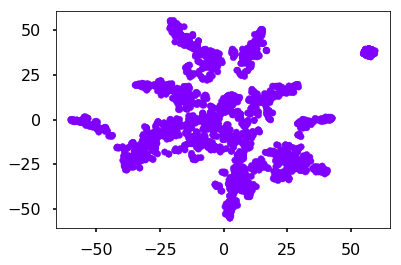

In [530]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0,verbose=2)
low_data = tsne_model.fit_transform(model_transformed)

num_points = 1877
num_clust = 10

colorize = []
for i in range(num_clust):
    for _ in range(num_points):
        # colorize.append(plt.cm.rainbow(i*20))
        
x,y = zip(*low_data)
plt.scatter(x, y, c=colorize, s=40);

In [528]:
model, model_transformed = nmf_cv(tf_vect2_transformed, n_comp=10)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1877 samples in 0.002s...
[t-SNE] Computed neighbors for 1877 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1877
[t-SNE] Computed conditional probabilities for sample 1877 / 1877
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.085s
[t-SNE] Iteration 50: error = 71.5460434, gradient norm = 0.1214279 (50 iterations in 2.368s)
[t-SNE] Iteration 100: error = 65.5536423, gradient norm = 0.0198547 (50 iterations in 1.681s)
[t-SNE] Iteration 150: error = 65.1880341, gradient norm = 0.0022966 (50 iterations in 1.649s)
[t-SNE] Iteration 200: error = 65.1220245, gradient norm = 0.0041442 (50 iterations in 1.653s)
[t-SNE] Iteration 250: error = 65.0985565, gradient norm = 0.0020528 (50 iterations in 1.705s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.098557
[t-SNE] Iteration 300: error = 0.9929306, gradient norm = 0.0008400 (50 iterations in 1.590s)

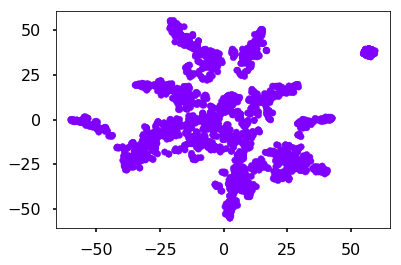

In [529]:
tsne_model = TSNE(n_components=2, random_state=0,verbose=2)
low_data = tsne_model.fit_transform(model_transformed)

num_points = 1877
num_clust = 12

colorize = []
for i in range(num_clust):
    for _ in range(num_points):
        colorize.append(plt.cm.rainbow(i*20))
x,y = zip(*low_data)
plt.scatter(x, y, c=colorize, s=40);

In [524]:
use_vectorizer(tf_vect2, tf_vect2_transformed)



-------LSA------


Topic  0
offer instrumentation apparatus material potential interest newly offer instrumentation newly offer apparatus laboratory material apparatus laboratory instrumentation apparatus instrumentation apparatus laboratory roundup information newly roundup information
Topic  1
cell science new use human research year study change gene
Topic  2
cell protein gene t t cell immune tumor dna expression rna
Topic  3
cell science cancer t t cell immune research disease tumor virus
Topic  4
cell science t t cell quantum material atom solar state electron
Topic  5
protein dna science gene rna structure complex genome research enzyme
Topic  6
virus vaccine zika antibody zika virus infect hiv infection viral ebola
Topic  7
carbon reaction c bond catalyst protein plant enzyme science climate
Topic  8
plant year reaction carbon gravitational star researcher new wave catalyst
Topic  9
ice protein dna year earth planet surface crater climate star


-------NMF------


Topic  0
wee

In [461]:
model_transformed

array([[ 0.03606022,  0.01463753,  0.13978575],
       [ 0.00702094,  0.01942883,  0.11309704],
       [ 0.01095464,  0.19735347,  0.17891467],
       ..., 
       [ 0.14641721,  0.03204007,  0.41867172],
       [ 0.0773476 ,  0.        ,  0.50839933],
       [ 0.02032465,  0.        ,  0.        ]])

In [472]:
y = [sorted(model_transformed[0])[0], sorted(model_transformed[0])[1]]
y2 = [sorted(model_transformed[1])[0], sorted(model_transformed[1])[1]]
y3 = [sorted(model_transformed[2])[0], sorted(model_transformed[2])[1]]
print(y, y2, y3, type(int(y[0])))

[0.014637531137500425, 0.036060217374697466] [0.0070209400416933725, 0.019428830908441649] [0.010954642979389383, 0.17891467207042108] <class 'int'>


In [488]:
x1 = model_transformed[:, 0].astype(np.int64)
x1

array([0, 0, 0, ..., 0, 0, 0])

In [517]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
plt.style.use("seaborn-poster")
%matplotlib inline

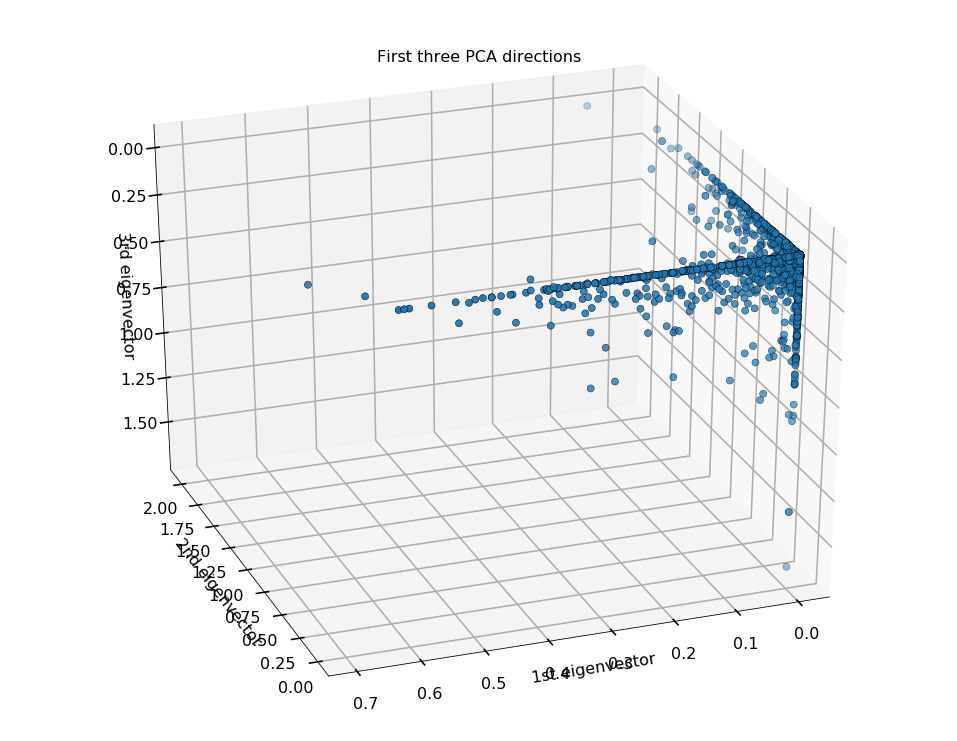

In [498]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
plt.style.use("seaborn-poster")
%matplotlib inline

fig = plt.figure(1, figsize=(13, 10))
ax = Axes3D(fig, elev=-150, azim=110)
#y = range(sorted(model_transformed[0])[0], sorted(model_transformed[0])[-1])
# plot transformed values (the three features that we have decomposed to) , colors correspond to target values
# c=y, cmap=plt.cm.cool, 
ax.scatter(model_transformed[:, 0], model_transformed[:, 1], model_transformed[:, 2], edgecolor='k', s=50)
ax.set_title("First three PCA directions", fontsize=16)
ax.set_xlabel("1st eigenvector",fontsize=16)
ax.set_ylabel("2nd eigenvector",fontsize=16)
ax.set_zlabel("3rd eigenvector",fontsize=16)

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

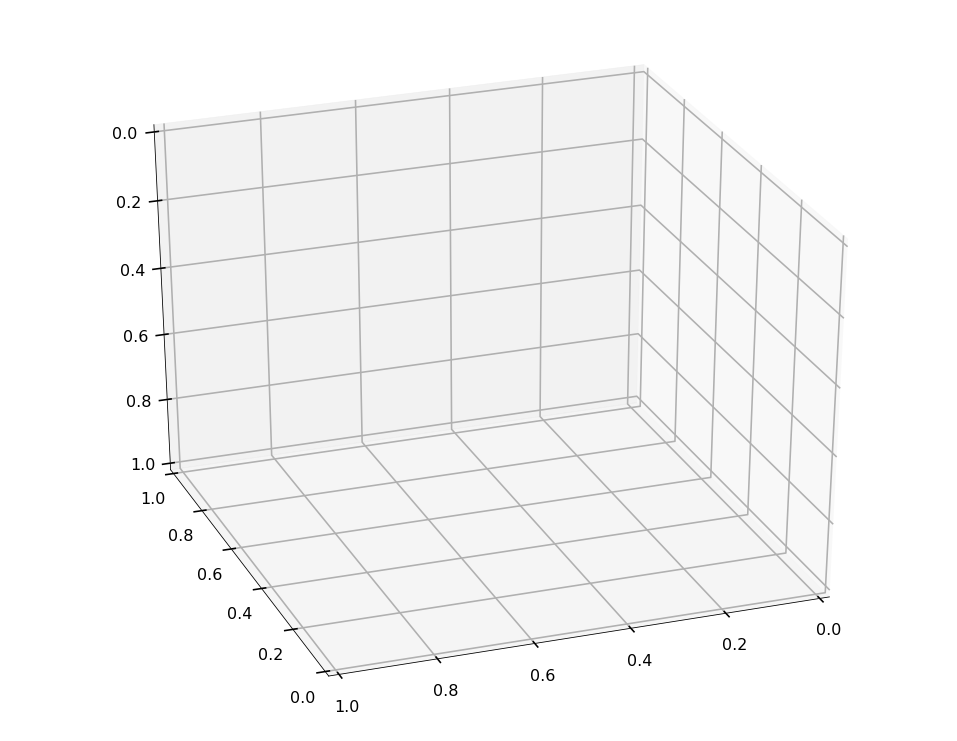

In [500]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
plt.style.use("seaborn-poster")
%matplotlib inline

fig = plt.figure(1, figsize=(13, 10))
ax = Axes3D(fig, elev=-150, azim=110)
#y = range(sorted(model_transformed[0])[0], sorted(model_transformed[0])[-1])
# plot transformed values (the three features that we have decomposed to) , colors correspond to target values
# c=y, cmap=plt.cm.cool, 
ax.scatter(cv_vect1_transformed[:, 0], cv_vect1_transformed[:, 1], cv_vect1_transformed[:, 2], edgecolor='k', s=50)
ax.set_title("First three PCA directions", fontsize=16)
ax.set_xlabel("1st eigenvector",fontsize=16)
ax.set_ylabel("2nd eigenvector",fontsize=16)
ax.set_zlabel("3rd eigenvector",fontsize=16)

In [518]:
print(len(model_transformed[:,0]), len(model_transformed[:,1]), len(model_transformed[:,2]))

1877 1877 1877


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1877 samples in 0.003s...
[t-SNE] Computed neighbors for 1877 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1877
[t-SNE] Computed conditional probabilities for sample 1877 / 1877
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.075s
[t-SNE] Iteration 50: error = 75.7101517, gradient norm = 0.0706795 (50 iterations in 2.637s)
[t-SNE] Iteration 100: error = 69.3957520, gradient norm = 0.0164440 (50 iterations in 1.939s)
[t-SNE] Iteration 150: error = 69.2752991, gradient norm = 0.0079197 (50 iterations in 1.876s)
[t-SNE] Iteration 200: error = 69.2555923, gradient norm = 0.0094416 (50 iterations in 1.905s)
[t-SNE] Iteration 250: error = 69.2422943, gradient norm = 0.0088520 (50 iterations in 1.902s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.242294
[t-SNE] Iteration 300: error = 1.1316512, gradient norm = 0.0008059 (50 iterations in 1.857s)

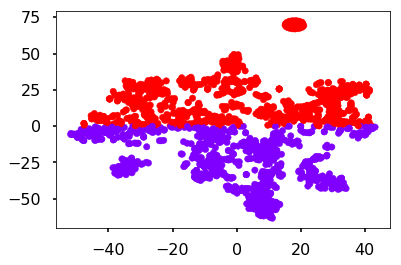

In [520]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0,verbose=2)
low_data = tsne_model.fit_transform(model_transformed)

num_points = 1877
num_clust = 12

colorize = []
for i in range(num_clust):
    for _ in range(num_points):
        colorize.append(plt.cm.rainbow(i*20))
x,y = zip(*low_data)
plt.scatter(x, y, c=plt.cm.rainbow(low_data[:,1]*20), s=40);

[(0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0, 1.0, 1.0),
 (0.5, 0.0,

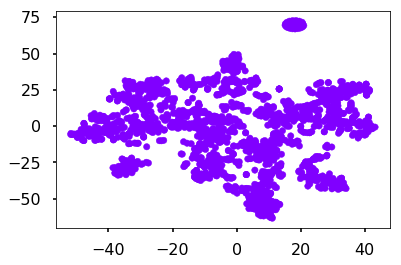

In [515]:
colorize = []
for i in range(num_clust):
    for _ in range(num_points):
        colorize.append(plt.cm.rainbow(i*20))
plt.scatter(x, y, c=colorize, s=40);
colorize[1800:1927]

In [ ]:
df_count_vect = pd.DataFrame(cv_data.toarray(), columns=count_vectorizer.get_feature_names())
df_count_vect.shape

In [455]:
model.explained_variance_ratio_

AttributeError: 'NMF' object has no attribute 'explained_variance_ratio_'

for 2016, the best topics were obtained from cv vect 1, features 5000, tokenizer 3:

-------NMF------


Topic  0
science research u.s new national world scientist institute health scientific
Topic  1
cell t t cell immune cancer stem mouse stem cell tumor tissue
Topic  2
state quantum electron atom magnetic field optical system material structure
Topic  3
system surface pluto solar new horizon new horizon datum solar system present
Topic  4
gene dna genome disease genetic human expression rna mutation cancer
Topic  5
change climate climate change global ice impact policy temperature increase model
Topic  6
virus zika vaccine antibody infect zika virus health human infection disease
Topic  7
material researcher information potential offer laboratory interest newly apparatus material potential
Topic  8
protein structure complex bind function site target rna membrane enzyme
Topic  9
new year study researcher human time scientist work people find
Topic  10
use reaction carbon c bond material high enzyme catalyst metal
Topic  11
issue page plant page issue specie system report response immune mechanism

# end!! end end end end

## Testing functions to reproduce above results

In [236]:
vect, vect_transformed = count_vectorizer(spacy_tokenizer, 5000, all_descriptions)

In [237]:
model, lda = LDA_options(vectorizer, 10)

In [238]:
lda[:3]

array([[ 0.00232595,  0.00232564,  0.00232618,  0.00232725,  0.00232609,
         0.97906605,  0.0023256 ,  0.00232587,  0.00232564,  0.00232574],
       [ 0.00312508,  0.00312504,  0.00312527,  0.82336822,  0.00312502,
         0.00312575,  0.003125  ,  0.15163022,  0.00312527,  0.00312513],
       [ 0.00125006,  0.00125002,  0.0012501 ,  0.98874822,  0.00125   ,
         0.00125038,  0.00125   ,  0.00125019,  0.00125056,  0.00125047]])

In [223]:
len(vect.get_feature_names())

5000

In [224]:
len(topic)

118353

In [225]:
len(vect.get_feature_names())

5000

In [228]:
a = [vect.get_feature_names()[i] for i in topic.argsort()[:-10 - 1:-1]]

IndexError: list index out of range

In [241]:
for ix, topic in enumerate(model.components_):
    b = " ".join([vect.get_feature_names()[i] for i in topic.argsort()[:-10 - 1:-1]])

In [240]:
display_topics(model, vect.get_feature_names(),10)

Topic  0
cell cancer t tumor t cell memory immune ray protein tissue
Topic  1
wave gravitational channel gravitational wave peptide physicist 3d hole calcium heart
Topic  2
science new research scientist world researcher human health year u.s
Topic  3
cell gene dna disease human mouse protein rna genetic genome
Topic  4
laboratory researcher information potential offer material apparatus newly instrumentation interest
Topic  5
use change 1 plant 2 issue protein model pageof issue pageof
Topic  6
system obama pluto new horizon new horizon barack obama president barack barack solar
Topic  7
use material quantum reaction light electron atom high metal molecule
Topic  8
earth ice surface ocean space planet year star gas large
Topic  9
virus antibody translation viral mrna partner hiv-1 envelope codon vaccine


In [158]:
display_topics(model, vect.get_feature_names(),10)

Topic  0
cell cancer t tumor t cell memory immune ray protein tissue
Topic  1
wave gravitational channel gravitational wave peptide physicist 3d hole calcium heart
Topic  2
science new research scientist world researcher human health year u.s
Topic  3
cell gene dna disease human mouse protein rna genetic genome
Topic  4
laboratory researcher information potential offer material apparatus newly instrumentation interest
Topic  5
use change 1 plant 2 issue protein model pageof issue pageof
Topic  6
system obama pluto new horizon new horizon barack obama president barack barack solar
Topic  7
use material quantum reaction light electron atom high metal molecule
Topic  8
earth ice surface ocean space planet year star gas large
Topic  9
virus antibody translation viral mrna partner hiv-1 envelope codon vaccine


In [153]:
display_topics(model, vect.get_feature_names(),10)

Topic  0
center cardiovascular target tunneling targeting metastatic importance real time provision tomography
Topic  1
wavelength growth factor chinese growth hormone persistent placoderm absorption house representative capable heterogeneity
Topic  2
scientific community new zealand resemble seasonal world large resistant hydrocarbon helminth year ago u.s science
Topic  3
center geneticist dopamine neuron distribute hydrocarbon muscular provision rocky geology pluto girl
Topic  4
lastyear resistant injection precise onset mechanical army nix intensity inthe
Topic  5
use new chimpanzee 1 play key 2–4 julythe new provision molecule paper publish paper new
Topic  6
tackle occurrence pollinator new zealand human body news belt prime belong song
Topic  7
use new mechanical r&d rearrange liquid embrace avenue historically mice morgan
Topic  8
edge image surveillance ongoing sparsely play central year ago stellar genetic engineering latitudinal
Topic  9
visible approval transplant virus outb

In [148]:
display_topics(model, vect.get_feature_names(),10)

Topic  0
center cardiovascular target tunneling targeting metastatic importance real time provision tomography
Topic  1
wavelength growth factor chinese growth hormone persistent placoderm absorption house representative capable heterogeneity
Topic  2
scientific community new zealand resemble seasonal world large resistant hydrocarbon helminth year ago u.s science
Topic  3
center geneticist dopamine neuron distribute hydrocarbon muscular provision rocky geology pluto girl
Topic  4
lastyear resistant injection precise onset mechanical army nix intensity inthe
Topic  5
use new chimpanzee 1 play key 2–4 julythe new provision molecule paper publish paper new
Topic  6
tackle occurrence pollinator new zealand human body news belt prime belong song
Topic  7
use new mechanical r&d rearrange liquid embrace avenue historically mice morgan
Topic  8
edge image surveillance ongoing sparsely play central year ago stellar genetic engineering latitudinal
Topic  9
visible approval transplant virus outb

In [182]:
vect, vect_transformed = count_vectorizer(spacy_tokenizer, 111971, all_descriptions)

In [183]:
model, lda = LDA_options(vectorizer, 10)

In [184]:
lda[:3]

array([[ 0.00232595,  0.00232564,  0.00232618,  0.00232725,  0.00232609,
         0.97906605,  0.0023256 ,  0.00232587,  0.00232564,  0.00232574],
       [ 0.00312508,  0.00312504,  0.00312527,  0.82336822,  0.00312502,
         0.00312575,  0.003125  ,  0.15163022,  0.00312527,  0.00312513],
       [ 0.00125006,  0.00125002,  0.0012501 ,  0.98874822,  0.00125   ,
         0.00125038,  0.00125   ,  0.00125019,  0.00125056,  0.00125047]])

In [185]:
display_topics(model, vect.get_feature_names(), 10)

Topic  0
36)is 3 little amyotrophic lateral ancestral early anabolic advance synthetic activity ultimately akhmediev aim design analysis trend
Topic  1
animal association activate n 4 provide activate nuclease agent purge aggressively judge 1 application activity deep 3 demonstrate active material
Topic  2
alloy catalyst afflict neurodegenerative alkama allure paleontologist animal robust alkyl arylamine activity likely active climate animal victimize ancient collagen
Topic  3
36)is act like abundant seafloor absurdity classical activity likely affect accord aim design allow distant act reduce act terminate
Topic  4
address legislation alkyl arylamine adapt agree design age 3 advance clock 1)their aficionado convince adaptation possibility adaptively alter
Topic  5
andean 4 polycrystalline 'll restore ago contrast -ryanodol addition organic aim design advocate offer agency esa agency endanger
Topic  6
amyloid associate aftermath sputnik ago large afflict neurodegenerative activity east

In [180]:
display_topics(model, vect.get_feature_names(), 10)

Topic  0
2 essa 2 achieve alarm house allosterically alarm morning activate nuclease access carbohydrate aeruginosa vogeley adversary align graphene
Topic  1
alter neural abscission schardon 2 policy absence adenosylmethionine sam administer 5% 1 achieve academic researcher 1–4 light abundance conventional
Topic  2
agency funder actually amplify africa million agency maximize alternative process africa startlingly accelerate fifth abu dis altitude allow darpa
Topic  3
2 essa abnormal meiotic 40-year 4-hectare accelerate fifth activity dependent adversary age incandescent abolish aboutbc reconcile
Topic  4
achieve bulk africa startlingly accompany increase adsorption 111 adaptation tissue action individual 1.3 actuator account baseline accounting open
Topic  5
allow switching 2 phenomenon 'll restore administration speak -ryanodol accurate enzymatic adversary active site additional impact additional gorilla
Topic  6
alain adaptation diverse admit wait actually amplify academy art actual

### Workflow for getting issues from each year

In [ ]:
url = 'http://science.sciencemag.org/content/by/year/2017'

response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"html5lib")

In [ ]:
link_search = soup.find_all(class_ = "highlight-image-linked")
link_search

In [ ]:
issues2 = []
for link in link_search:
    a = link.get('href')
    issues2.append(a)

In [ ]:
len(issues)

In [ ]:
url = 'http://science.sciencemag.org/content/by/year/2016'

response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"html5lib")

In [ ]:
link_search = soup.find_all(class_ = "highlight-image-linked")
link_search

### Find workflow for getting the links to articles from each issue

In [ ]:
path = 'http://science.sciencemag.org'
response = requests.get(path + issues2[0])
page = response.text
soup = BeautifulSoup(page,"html5lib")

In [ ]:
classes = ['abstract first', 'editor-summary first', 'summary first']
i = 1
article_content_links = []
for entry in classes:
    search = soup.find_all(class_ = entry)
    for item in search:
        article_content_links.append(item.find('a').get('href'))

In [ ]:
article_content_links

### workflow 

In [ ]:
content_classes = ['section editor-summary', 'section summary', 'section abstract']

In [ ]:
article_content_links[0]

In [ ]:
path = 'http://science.sciencemag.org'
response = requests.get(path + article_content_links[0])
page = response.text
soup = BeautifulSoup(page,"html5lib")
title = soup.find(class_ = 'highwire-cite-title').text
print(title)
for entry in content_classes:
    a = soup.find(class_ = entry)
    if a:
        # print(a.text)
        print(a.find('p').text)

In [ ]:
test = 'http://science.sciencemag.org/content/308/5719'
response = requests.get(test)
page = response.text
soup = BeautifulSoup(page,"html5lib")

In [ ]:
'abstract first', 'editor-summary first'
title_ref = soup.find_all(class_ = 'summary first')
title_ref

In [ ]:
 next_base = 'http://science.sciencemag.org/'

In [137]:
all_descriptions[8]

'H2O exists in two spin isomers, ortho and para, in a ratio of 3:1 at room temperature. Some astronomical observations have found water with a ratio of less than 3, thought to be due to water being photodesorbed from ice that had been formed at very low temperatures (≾30 K). Hama et al. tested this idea in the laboratory, by forming water ice at low temperature and then photodesorbing it to measure the ortho:para ratio. They found a ratio of 3, even at 10 K. Thus, another explanation for the low ratios in some astronomical objects must be found.'

In [138]:
doctest = re.sub('\s\d+(\s)?(,)?', '', all_descriptions[8])

In [139]:
doctest

'H2O exists in two spin isomers, ortho and para, in a ratio of:1 at room temperature. Some astronomical observations have found water with a ratio of less than thought to be due to water being photodesorbed from ice that had been formed at very low temperatures (≾30 K). Hama et al. tested this idea in the laboratory, by forming water ice at low temperature and then photodesorbing it to measure the ortho:para ratio. They found a ratio of even atK. Thus, another explanation for the low ratios in some astronomical objects must be found.'